# Modelling

In [1]:
import pandas as pd
from sklearn.dummy import DummyClassifier
from transformers import pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import auc, roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import warnings
import time
warnings.filterwarnings("ignore")

## Load the Data

I'll start by loading the preprocesses data (for the pretrained models) and the training and testing sets (for the supervised learning models)

In [2]:
preprocessed_data = pd.read_csv('../data/preprocessed_data.csv', index_col=0)

In [3]:
preprocessed_data.head(3)

,stop_text,good_review
0,my fav-my fav ice cream ever. i could eat time...,Good
1,so good-they real chunk cookie dough chocolate...,Good
2,"nan-i personally like vanilla, addition ice cr...",Good


In [4]:
X = preprocessed_data.copy()
X.drop(['stop_text'], axis=1, inplace=True)
y = preprocessed_data['good_review']

In [5]:
X_train = pd.read_csv('../data/X_train.csv', index_col=0)
y_train = pd.read_csv('../data/y_train.csv', index_col=0)['good_review']
X_test = pd.read_csv('../data/X_test.csv', index_col=0)
y_test = pd.read_csv('../data/y_test.csv', index_col=0)['good_review']

## Model Selection

I have selected 5 models to test:

* Multinomial Naive Bayes
* Passive Aggressive Classifier
* Logistic Regression
* Hugging Face Transformer
* SVM

Each of the unsupervised learning models will be cross validated and tuned using `RandomizedSearchCV` with 10 folds.

### Dummy Classifier

Before I even begin modelling, I'll start with a baseline model, `DummyClassifier`.

In [6]:
dummy = DummyClassifier(strategy='stratified')

In [7]:
dummy.fit(X_train, y_train)

DummyClassifier(strategy='stratified')

In [8]:
y_predict_dummy = dummy.predict(X_test)

In [9]:
dummy_report = classification_report(y_test, y_predict_dummy)
print(dummy_report)

              precision    recall  f1-score   support

         Bad       0.22      0.21      0.22      1392
        Good       0.79      0.79      0.79      5091

    accuracy                           0.67      6483
   macro avg       0.50      0.50      0.50      6483
weighted avg       0.66      0.67      0.67      6483



Performance is just about as I expected... pretty bad. Let's see how the rest of the models perform.

### Multinomial Naive Bayes

In [10]:
start_time = time.time()
nb = MultinomialNB()

In [11]:
alpha = [i/10 for i in range(0, 11)]
param_dist = {"alpha": alpha}

In [12]:
rand_search = RandomizedSearchCV(estimator=nb, param_distributions=param_dist, cv=10, random_state=1)
rand_search.fit(X_train, y_train)

RandomizedSearchCV(cv=10, estimator=MultinomialNB(),
                   param_distributions={'alpha': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5,
                                                  0.6, 0.7, 0.8, 0.9, 1.0]},
                   random_state=1)

In [13]:
best_nb = rand_search.best_estimator_

In [14]:
print(best_nb)

MultinomialNB(alpha=0.1)


In [15]:
nb = best_nb
nb.fit(X_train, y_train)
y_predict_nb = nb.predict(X_test)
end_time = time.time()

In [16]:
nb_report = classification_report(y_test, y_predict_nb)
print(nb_report)
print("Execution time: %s min" % ((end_time - start_time)/60))

              precision    recall  f1-score   support

         Bad       0.93      0.60      0.73      1392
        Good       0.90      0.99      0.94      5091

    accuracy                           0.91      6483
   macro avg       0.92      0.80      0.84      6483
weighted avg       0.91      0.91      0.90      6483

Execution time: 0.18126606941223145 min


This is a pretty good f1. The f1 for the *Bad* class could certainly be better. The recall is on the lower end. Maybe the next models will do a better job. On the bright side, this took barely any time to complete.

### Passive Aggressive Classifier

In [17]:
start_time = time.time()
pag = PassiveAggressiveClassifier()

In [18]:
fit_intercept = [False, True]
max_iter = [i*100 for i in range(1,20)]
param_dist = {"fit_intercept": fit_intercept,
              "max_iter": max_iter}

In [19]:
rand_search = RandomizedSearchCV(estimator=PassiveAggressiveClassifier(), param_distributions=param_dist, cv=10, random_state=1)

In [20]:
rand_search.fit(X_train, y_train)

RandomizedSearchCV(cv=10, estimator=PassiveAggressiveClassifier(),
                   param_distributions={'fit_intercept': [False, True],
                                        'max_iter': [100, 200, 300, 400, 500,
                                                     600, 700, 800, 900, 1000,
                                                     1100, 1200, 1300, 1400,
                                                     1500, 1600, 1700, 1800,
                                                     1900]},
                   random_state=1)

In [21]:
best_pag = rand_search.best_estimator_

In [22]:
print(best_pag)

PassiveAggressiveClassifier(fit_intercept=False, max_iter=400)


In [23]:
pag = best_pag
pag.fit(X_train, y_train)
y_predict_pag = pag.predict(X_test)
end_time = time.time()

In [24]:
pag_report = classification_report(y_test, y_predict_pag)
print(pag_report)
print("Execution time: %s min" % ((end_time - start_time)/60))

              precision    recall  f1-score   support

         Bad       0.84      0.80      0.82      1392
        Good       0.94      0.96      0.95      5091

    accuracy                           0.92      6483
   macro avg       0.89      0.88      0.88      6483
weighted avg       0.92      0.92      0.92      6483

Execution time: 1.3027409315109253 min


This is slightly better than the previous model, though the run time is a bit longer, but still not much of a worry. 

### Logistic Regression

In [25]:
start_time = time.time()
lr = LogisticRegression()

In [26]:
dual = [False]
l1_ratio = [i/10 for i in range(0, 10)]
param_dist = {"dual": dual,
              "l1_ratio": l1_ratio}

In [27]:
rand_search = RandomizedSearchCV(lr, param_distributions=param_dist, scoring='f1', cv=10, random_state=1)

In [28]:
rand_search.fit(X_train, y_train)

RandomizedSearchCV(cv=10, estimator=LogisticRegression(),
                   param_distributions={'dual': [False],
                                        'l1_ratio': [0.0, 0.1, 0.2, 0.3, 0.4,
                                                     0.5, 0.6, 0.7, 0.8, 0.9]},
                   random_state=1, scoring='f1')

In [29]:
best_lr = rand_search.best_estimator_
print(rand_search.best_estimator_)

LogisticRegression(l1_ratio=0.0)


In [30]:
y_predict_lr = best_lr.predict(X_test)
end_time = time.time()

In [31]:
lr_report = classification_report(y_test, y_predict_lr)
print(lr_report)
print("Execution time: %s min" % ((end_time - start_time)/60))

              precision    recall  f1-score   support

         Bad       0.88      0.77      0.82      1392
        Good       0.94      0.97      0.96      5091

    accuracy                           0.93      6483
   macro avg       0.91      0.87      0.89      6483
weighted avg       0.93      0.93      0.93      6483

Execution time: 1.367861771583557 min


Leave it to classic logistic regression to be the best performing supervised model. This has the best f1 of the three so far, but also has the longest run time -- just something to note.

### Hugging Face Model

For the hugging face transformer model, I'll use a smaller portion of the data. This is because the execution time of the model takes a significantly long time. The model is pretrained, so the performance results should still be valid even though I've used a smaller data set. I'll run the model for 2000 records, which is just around 10% of the original data size.

In [32]:
def hugging_face(text):
    classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli")
    classification = classifier(text, candidate_labels=["Good", "Bad"])
    max_value = max(classification['scores'])
    max_index = classification['scores'].index(max_value)
    return classification['labels'][max_index]

In [33]:
start_time = time.time()
n = 2000
y_predict_hug = preprocessed_data.iloc[0:n]['stop_text'].apply(hugging_face)
end_time = time.time()

In [34]:
print("Execution time: %s hours" % ((end_time - start_time)/3600))

Execution time: 4.636090535521507 hours


In [35]:
pretrained_report = classification_report(y[0:n], y_predict_hug)
print(pretrained_report)

              precision    recall  f1-score   support

         Bad       0.85      0.77      0.81       426
        Good       0.94      0.96      0.95      1574

    accuracy                           0.92      2000
   macro avg       0.89      0.87      0.88      2000
weighted avg       0.92      0.92      0.92      2000



### SVM

In [36]:
start_time = time.time()
svm = SVC()

In [37]:
kernel = ['linear', 'poly', 'rbf', 'sigmoid', 'precomputed']
shrinking = [True, False]
decision_function_shape = ['ovo', 'ovr']
param_dist = {"kernel": kernel,
              "shrinking": shrinking,
              "decision_function_shape": decision_function_shape}
param_dist = {}

In [38]:
rand_search = RandomizedSearchCV(svm, param_distributions=param_dist, scoring='f1', n_iter=5, cv=10, random_state=1)

In [39]:
rand_search.fit(X_train, y_train)

RandomizedSearchCV(cv=10, estimator=SVC(), n_iter=5, param_distributions={},
                   random_state=1, scoring='f1')

In [40]:
best_svm = rand_search.best_estimator_
print(rand_search.best_estimator_)

SVC()


In [41]:
y_predict_svm = best_svm.predict(X_test)
end_time = time.time()

In [42]:
svm_report = classification_report(y_test, y_predict_svm)
print(lr_report)
print("Execution time: %s min" % ((end_time - start_time)/60))

              precision    recall  f1-score   support

         Bad       0.88      0.77      0.82      1392
        Good       0.94      0.97      0.96      5091

    accuracy                           0.93      6483
   macro avg       0.91      0.87      0.89      6483
weighted avg       0.93      0.93      0.93      6483

Execution time: 8.43856616417567 min


## Summary

All of the models performed pretty well. However, SVM and Hugging Face Transformer took the longest to run, so there is really no benefit in choosing either of those. So, for a balance between performance and speed, the best model here is Logistic Regression.

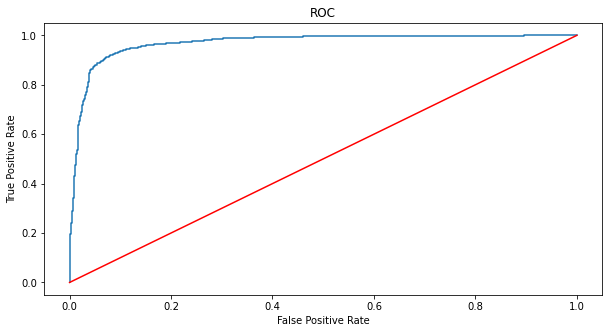

In [47]:
y_scores_lr = best_lr.predict_proba(X_test)[:,1]
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_scores_lr, pos_label="Good")
plt.figure(figsize=(10, 5))
plt.plot(false_positive_rate, true_positive_rate)
plt.plot([0, 1], [0, 1], 'r')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.show()